<a href="https://colab.research.google.com/github/GeoTurkey/GMT_COURSES/blob/main/Time_Series_analysis_on_multivariate_data_in_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing necessary libraries

import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import os
import datetime
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional
from keras.layers import Dense
from keras.layers import Dropout
from numpy import concatenate
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from sklearn.metrics import mean_squared_error
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 22, 10

url="https://raw.githubusercontent.com/GeoTurkey/GMT_COURSES/main/city_day.csv"
#reading the csv file into pandas data frame
data = pd.read_csv(url, index_col="Date", parse_dates=True)

#selecting only those rows, which has City as 'Delhi'
df = data.loc[data['City']=='Delhi']

df.describe()

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
count,2007.000000,1932.000000,2007.000000,2007.000000,2009.000000,2000.000000,2009.000000,1899.000000,1925.00000,2009.000000,2009.000000,1228.000000,1999.000000
mean,117.196153,232.809229,38.985595,50.785182,58.567023,41.997150,1.976053,15.901253,51.32361,3.544480,17.185042,1.438339,259.487744
std,82.912945,121.873025,33.389456,22.696721,37.690350,17.301221,2.560253,7.966770,26.06234,2.431232,15.291597,2.377762,119.537333
min,10.240000,18.590000,3.570000,10.630000,0.000000,6.780000,0.000000,2.340000,6.94000,0.000000,0.000000,0.000000,29.000000
25%,57.095000,137.040000,15.895000,33.895000,31.150000,31.157500,0.910000,10.335000,33.71000,1.870000,6.650000,0.110000,161.500000
50%,94.620000,216.730000,27.200000,47.150000,52.750000,38.040000,1.240000,14.450000,44.44000,2.960000,12.750000,0.650000,257.000000
75%,153.030000,311.667500,50.790000,63.570000,75.360000,48.792500,1.870000,19.700000,60.84000,4.680000,23.200000,1.970000,345.500000
max,685.360000,796.880000,221.030000,162.500000,254.800000,166.700000,30.440000,71.560000,257.73000,20.640000,103.000000,23.300000,716.000000


In [ ]:
df.isnull().sum()
#drop unnecessary columns
df = df.drop(columns=['City','AQI_Bucket','Xylene'])

#fill the null rows with the mean of respective columns
df = df.fillna(df.mean())

In [ ]:
df

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,AQI
Date,,,,,,,,,,,,
2015-01-01,313.22,607.98,69.16,36.39,110.59,33.85,15.20,9.25,41.68,14.36,24.86,472.0
2015-01-02,186.18,269.55,62.09,32.87,88.14,31.83,9.54,6.65,29.97,10.55,20.09,454.0
2015-01-03,87.18,131.90,25.73,30.31,47.95,69.55,10.61,2.65,19.71,3.91,10.23,143.0
2015-01-04,151.84,241.84,25.01,36.91,48.62,130.36,11.54,4.63,25.36,4.26,9.71,319.0
2015-01-05,146.60,219.13,14.01,34.92,38.25,122.88,9.20,3.33,23.20,2.80,6.21,325.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-27,39.80,155.94,10.88,21.46,22.47,31.43,0.87,10.38,18.88,1.69,19.99,112.0
2020-06-28,59.52,308.65,12.67,21.60,23.86,29.27,0.94,10.70,18.05,1.71,25.13,196.0
2020-06-29,44.86,184.12,10.50,21.57,21.94,27.97,0.88,11.58,26.61,2.13,23.80,233.0


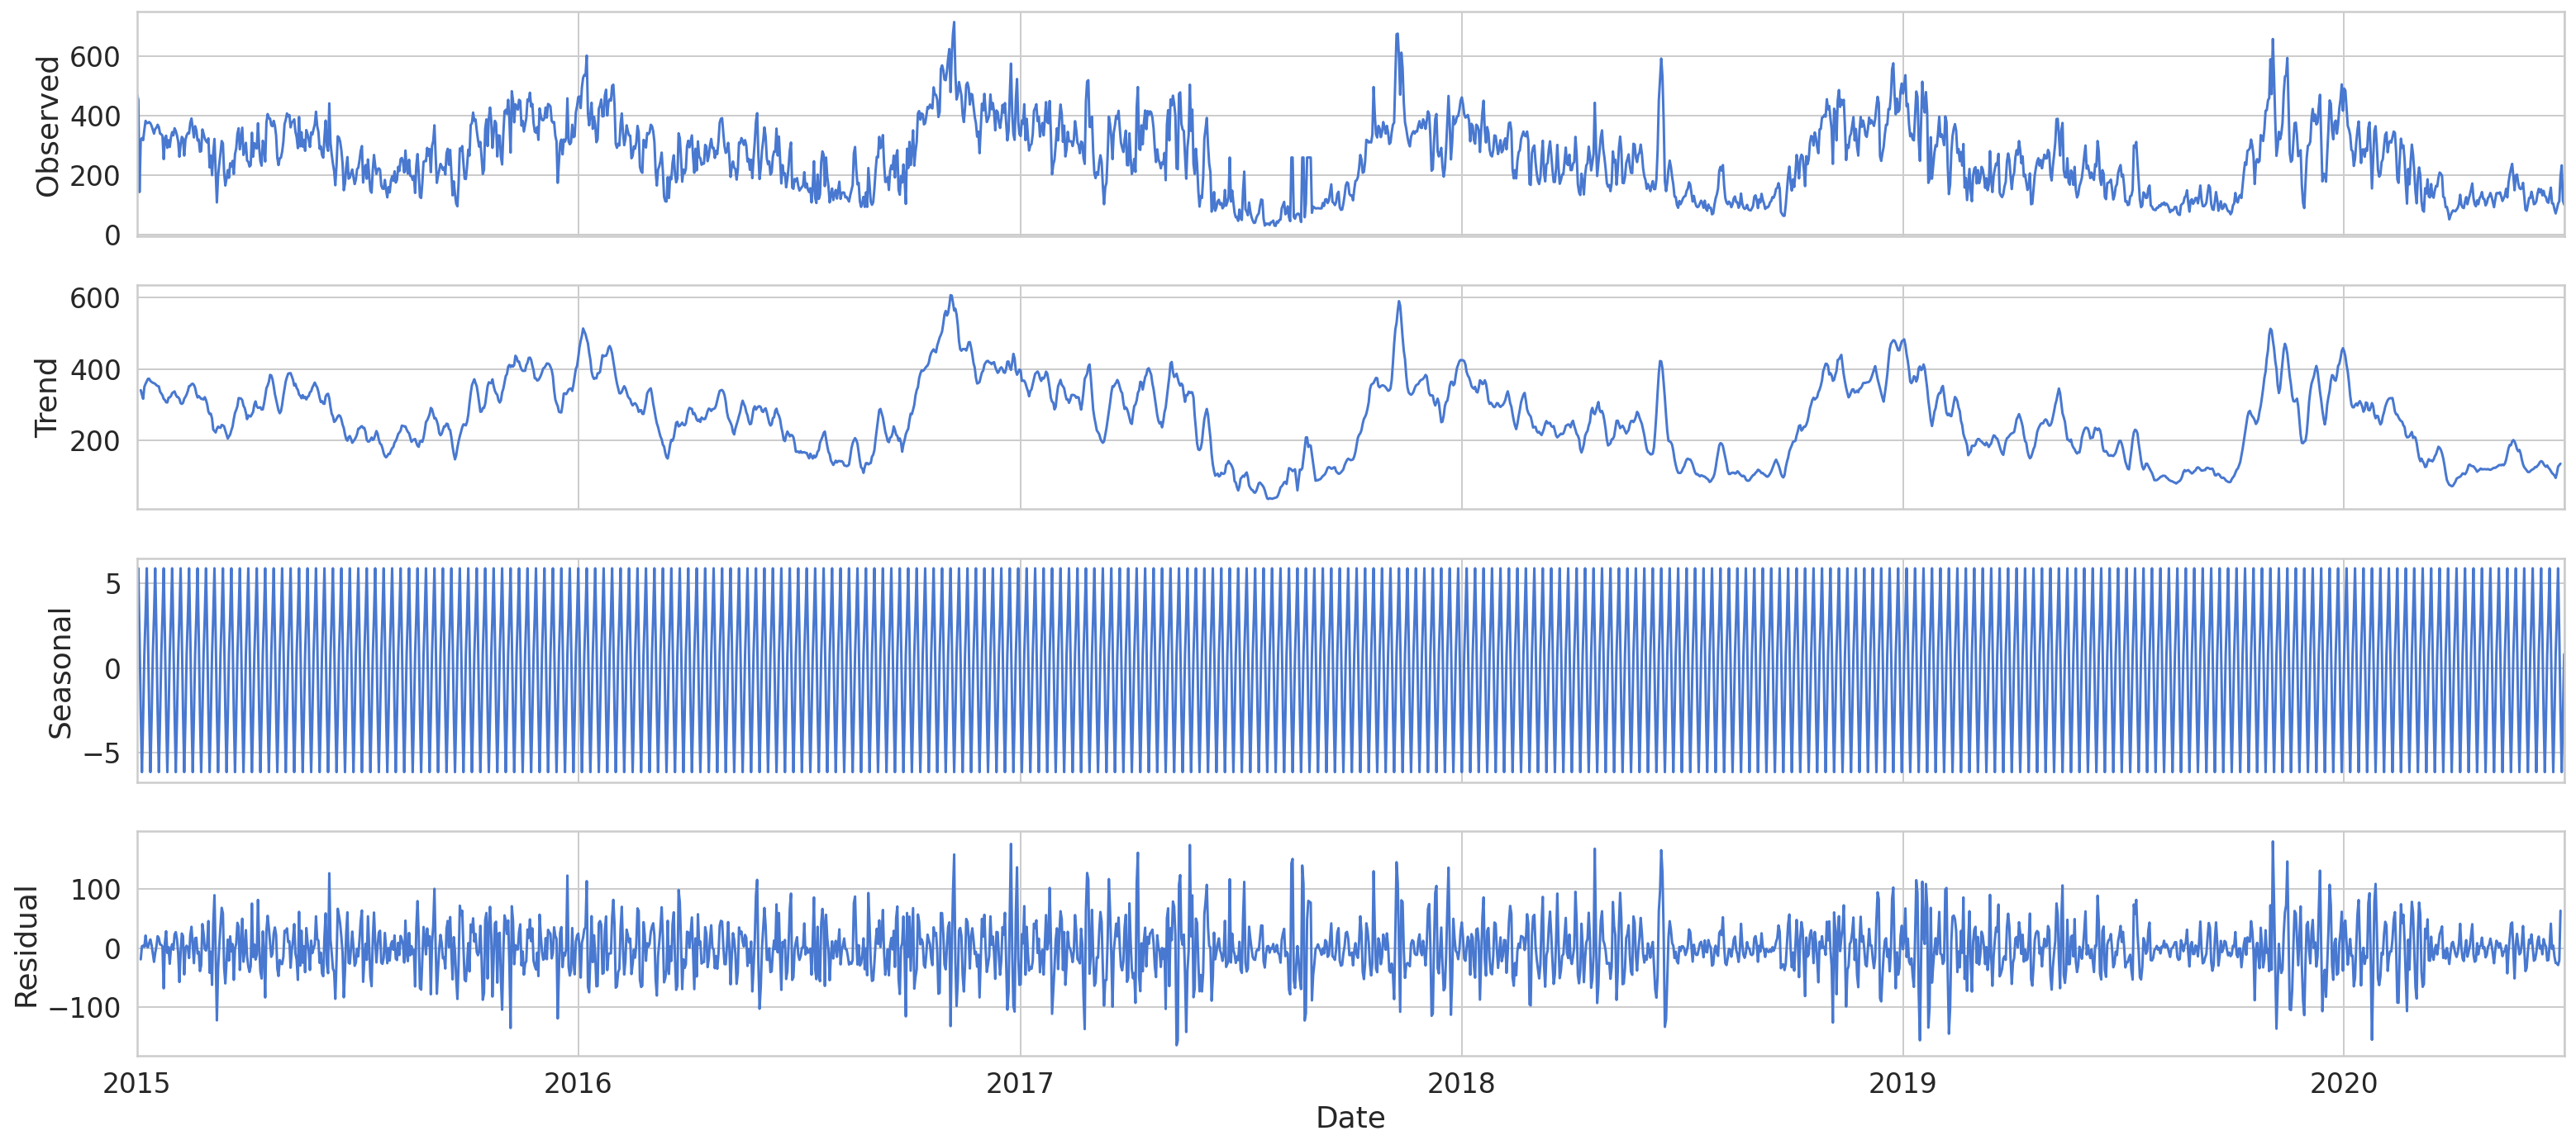

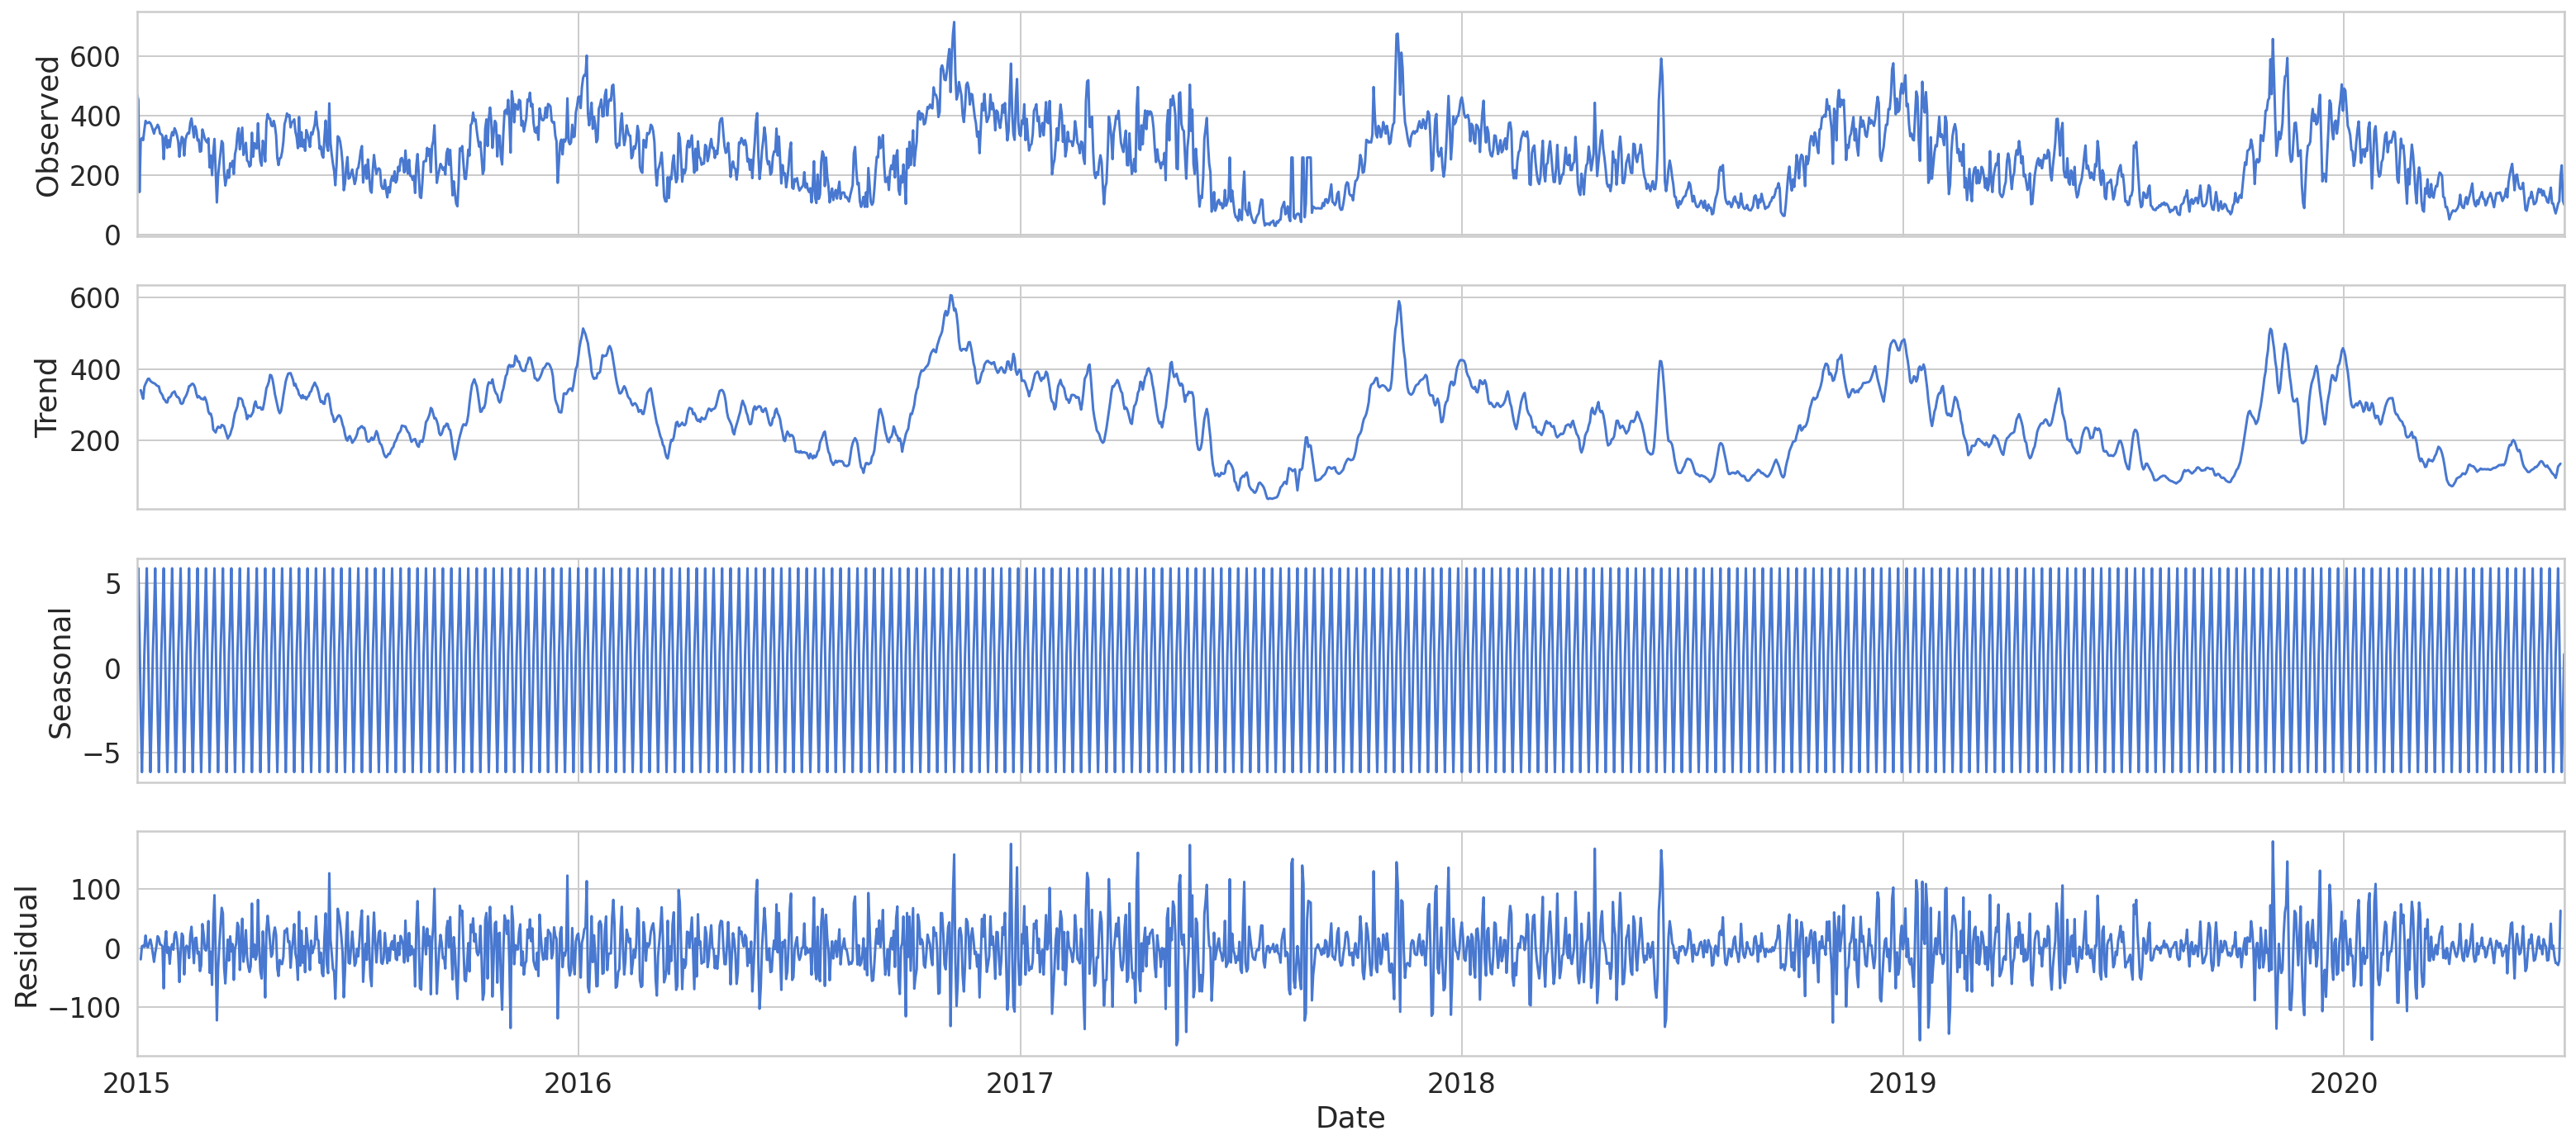

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df["AQI"], model='additive')
result.plot()


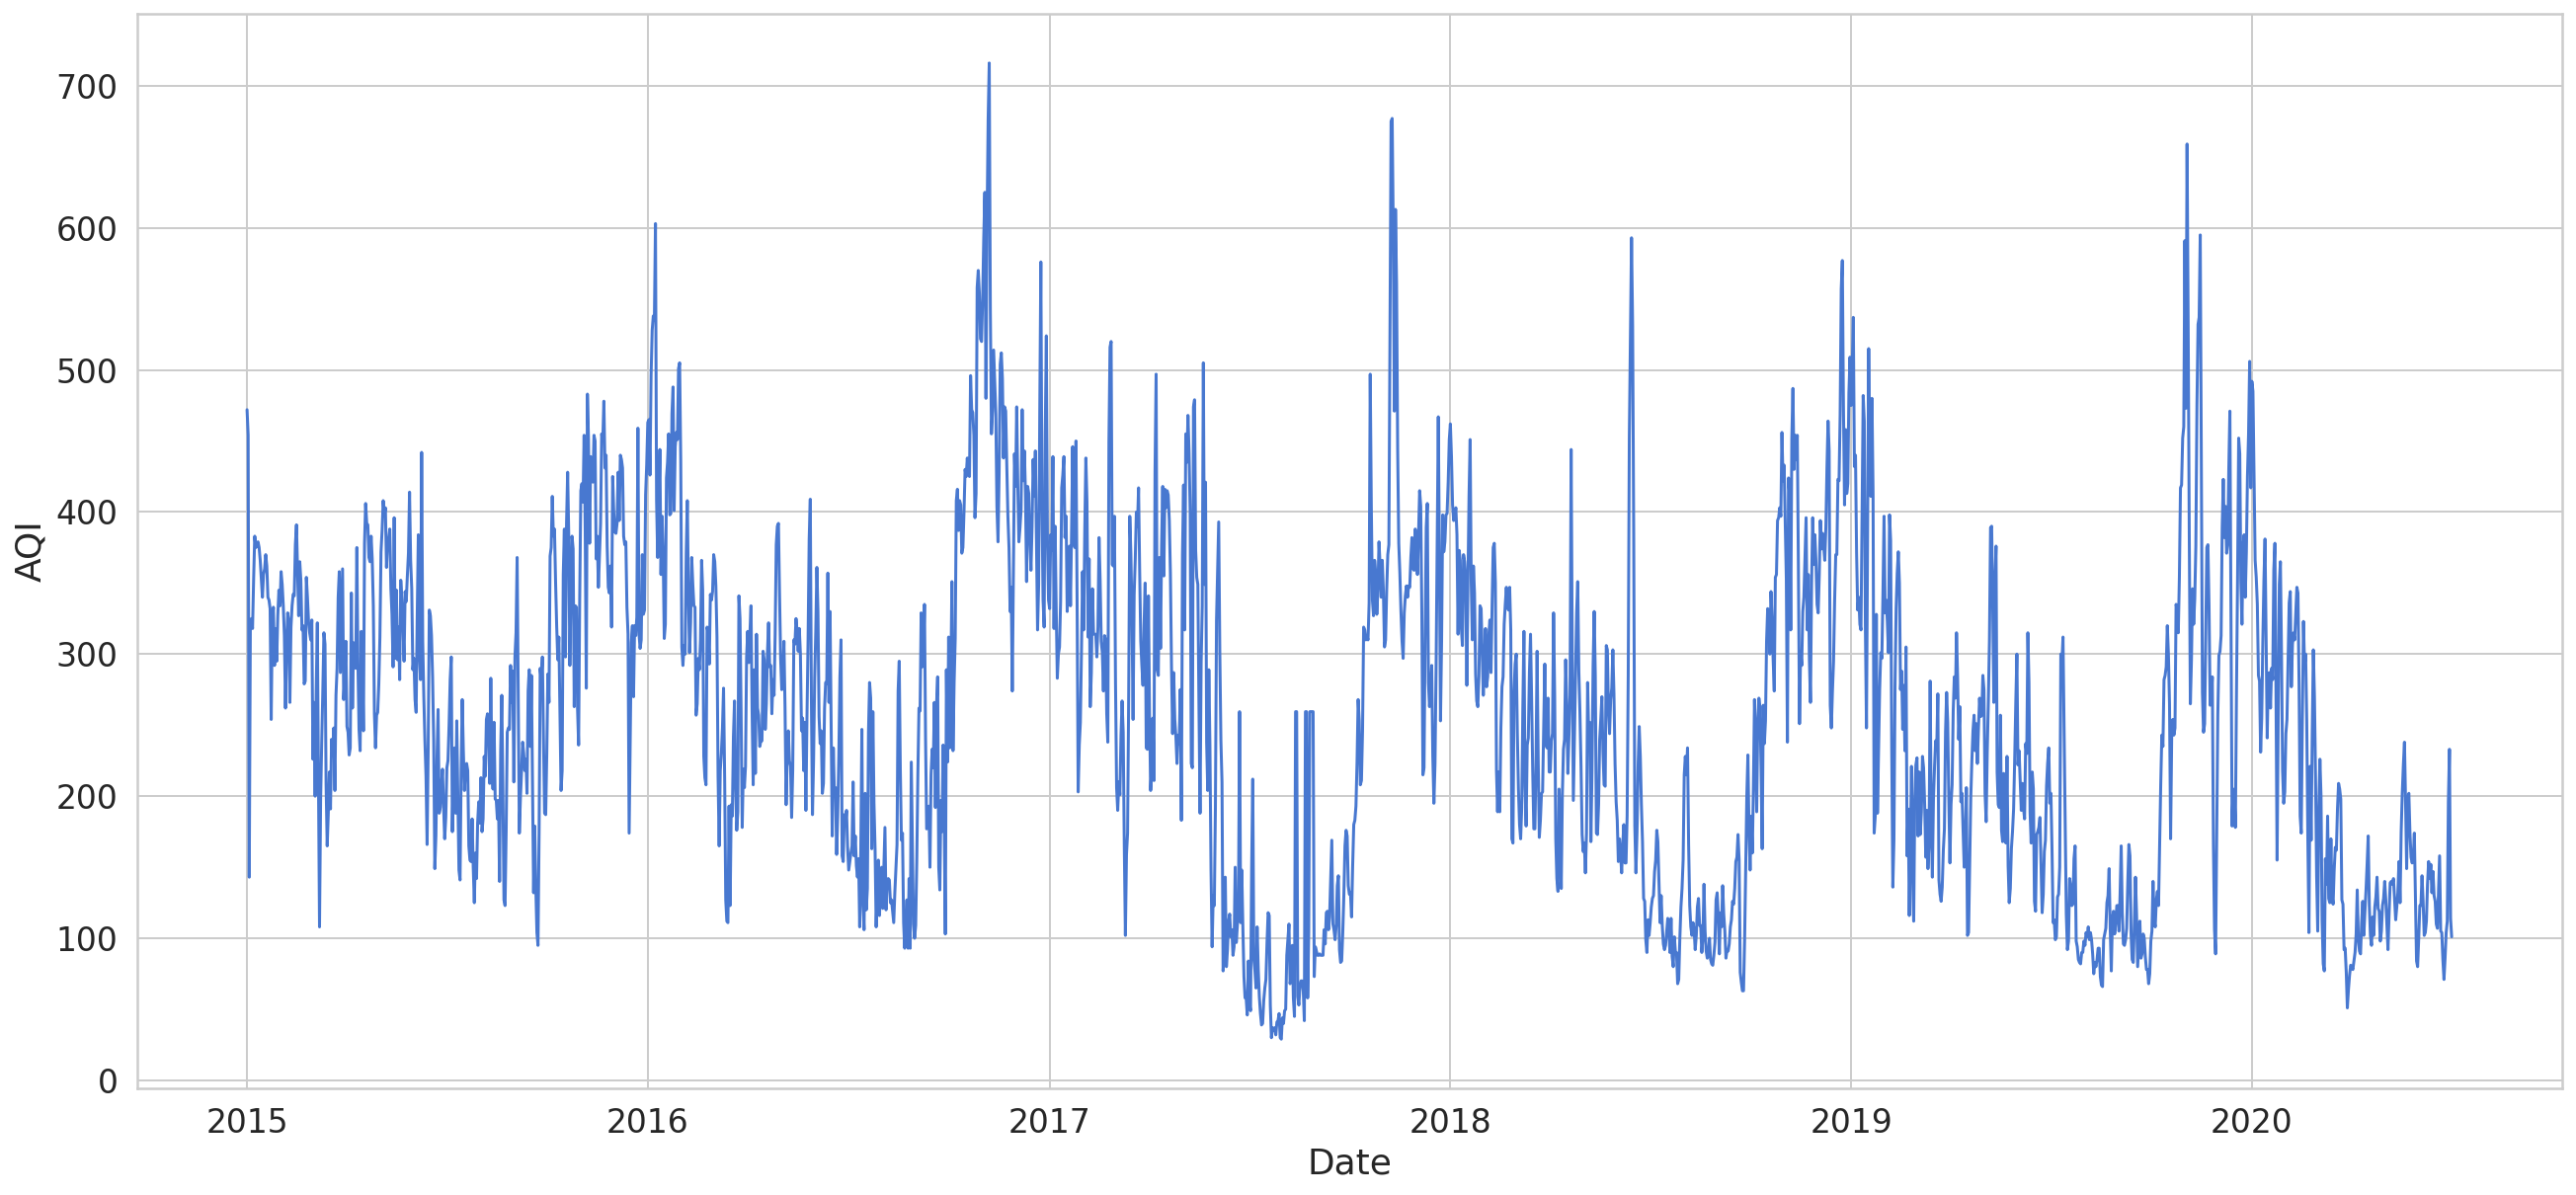

In [ ]:
sns.lineplot(x=df.index, y="AQI", data=df);

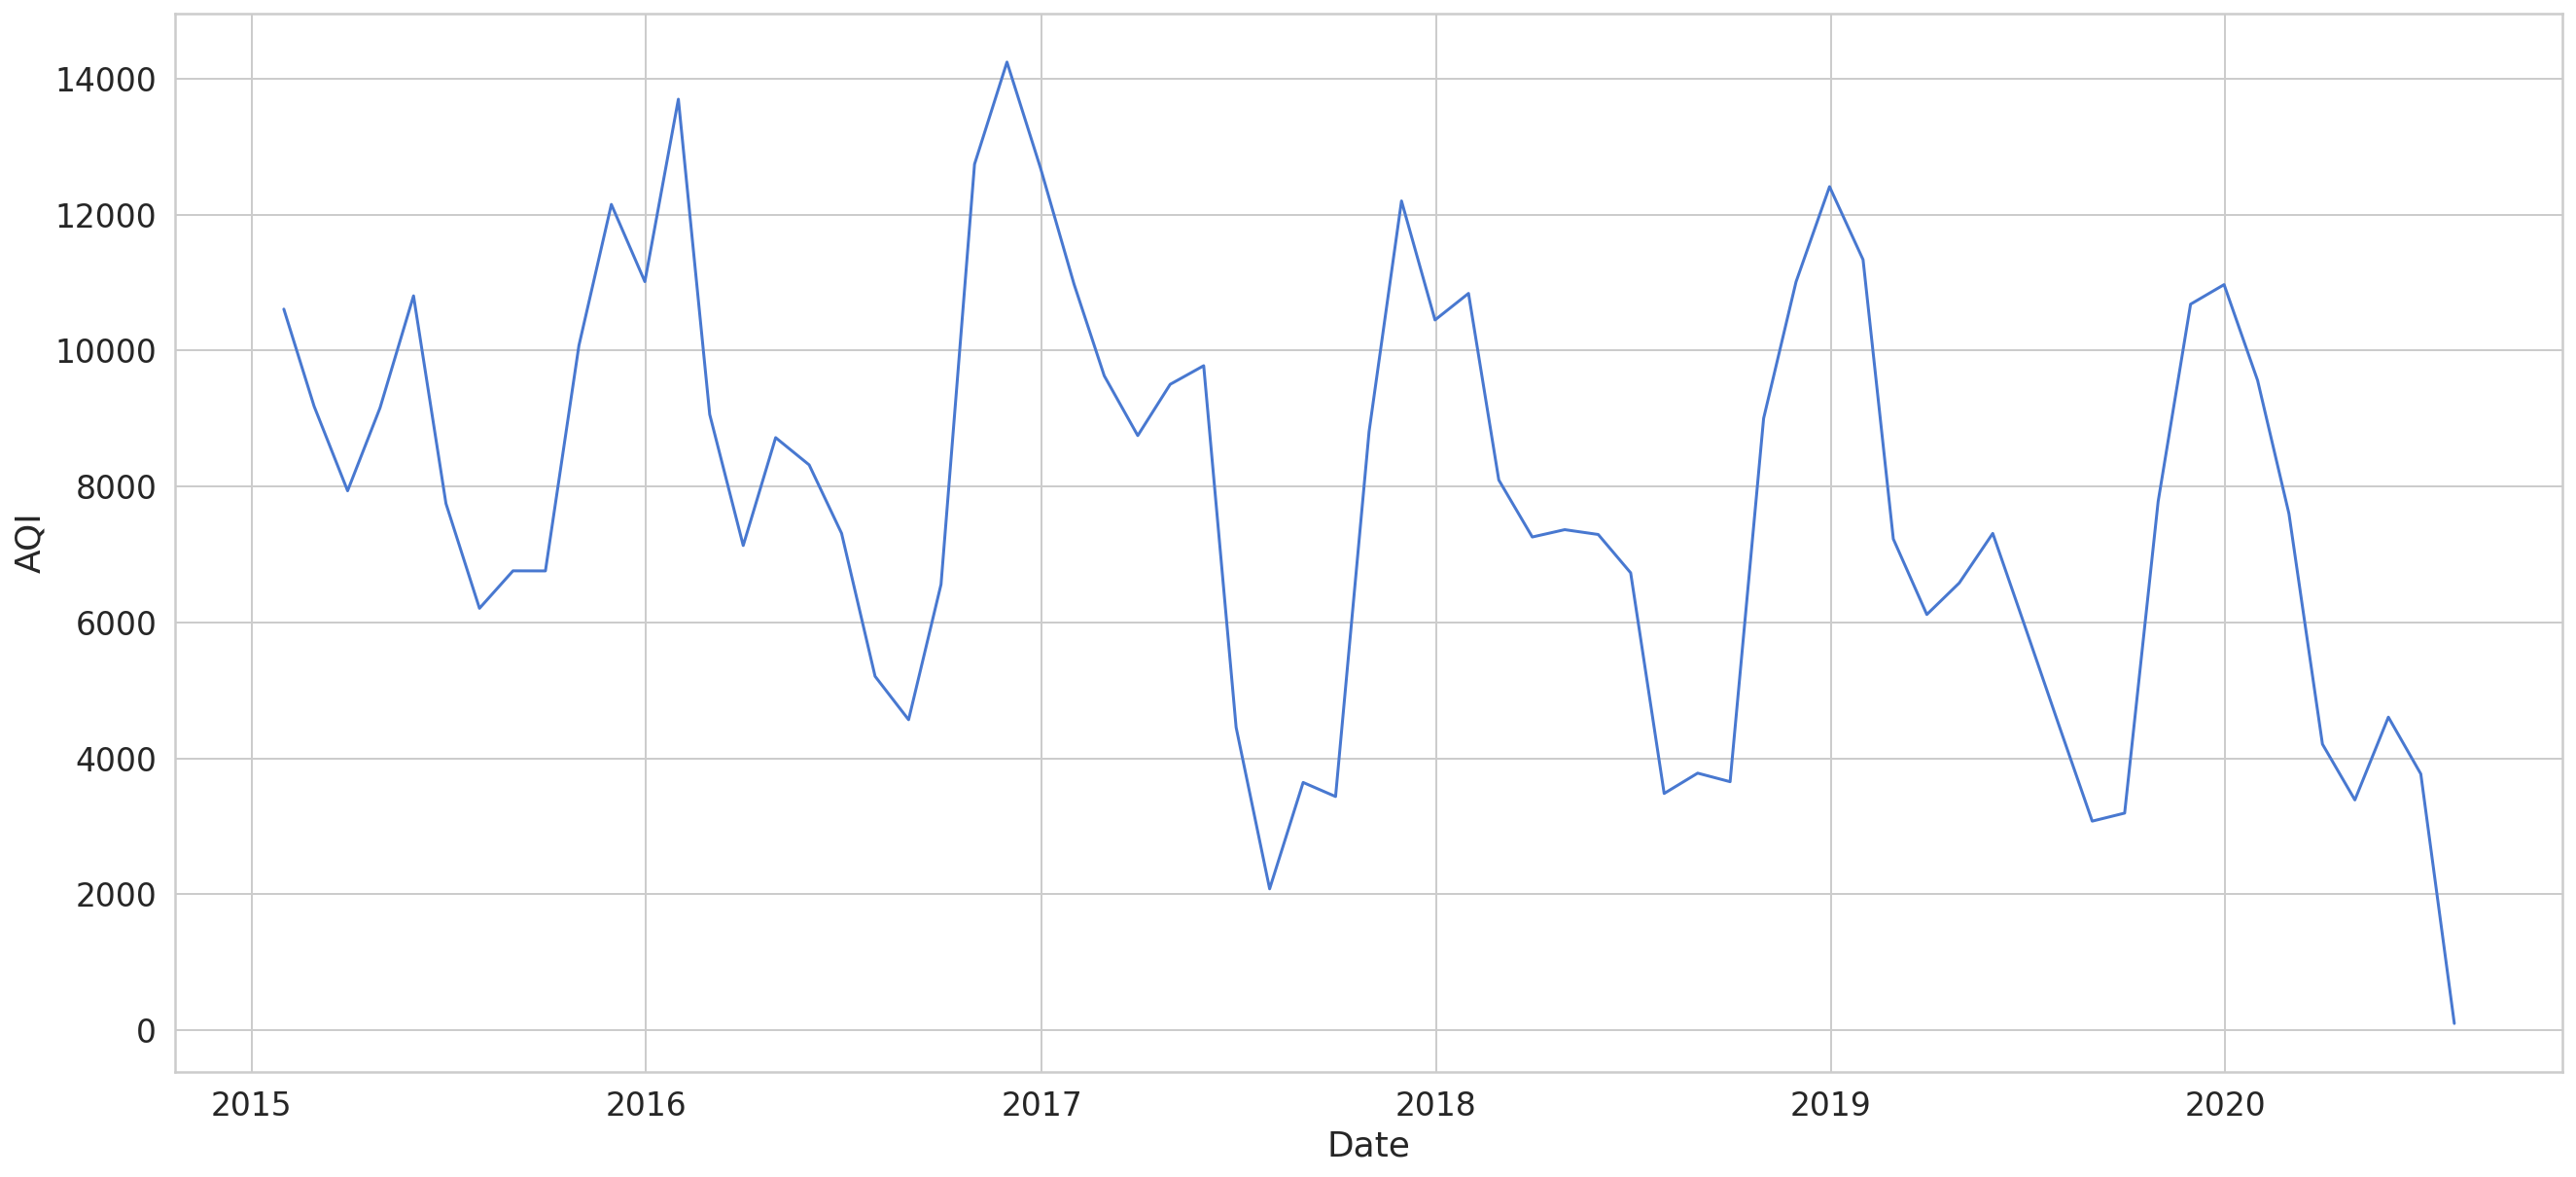

In [ ]:


df_by_month = df.resample('M').sum()

sns.lineplot(x=df_by_month.index, y="AQI", data=df_by_month);



In [ ]:
dataset = df.filter(["AQI"])


time_steps = 7
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

1607 402


In [ ]:
train.shape, test.shape

((1607, 12), (402, 12))

In [ ]:
df.columns

Index(['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3',
       'Benzene', 'Toluene', 'AQI'],
      dtype='object')

In [ ]:
f_columns = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene']

In [ ]:
from sklearn.preprocessing import RobustScaler

f_transformer = RobustScaler()
aqi_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
aqi_transformer = f_transformer.fit(train[["AQI"]])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['AQI'] = aqi_transformer.transform(train[['AQI']])

test.loc[:,f_columns]= f_transformer.transform(test[f_columns].to_numpy())
test['AQI'] = aqi_transformer.transform(test[['AQI']])


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

In [ ]:
def create_dataset(X, y, time_steps=1):
  Xs, ys = [], []
  for i in range (len(X) - time_steps):
    v = X.iloc[i:(i+time_steps)].values
    Xs.append(v)
    ys.append(y.iloc[i+time_steps])
  return np.array(Xs), np.array(ys)

In [ ]:
test_data = df[train_size - time_steps:]

def create_dataset_test(X, y, time_steps=1):
  Xs, ys = [], []
  for i in range (test_size):
    v = X.iloc[i:(i+time_steps)].values
    Xs.append(v)
    ys.append(y.iloc[i+time_steps])
  return np.array(Xs), np.array(ys)

In [ ]:

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.AQI, time_steps)
X_test, y_test = create_dataset_test(test_data, test_data.AQI, time_steps)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1600, 7, 12) (1600,)
(402, 7, 12) (402,)


In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(units=32, return_sequences=True), input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Bidirectional(LSTM(units=32)))
model.add(Dropout(rate=0.2))
model.add(Dense(units=1))
model.compile(loss="mean_squared_error", optimizer = "adam")

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=4,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/50
360/360 [==============================] - 4s 12ms/step - loss: 0.2864 - val_loss: 0.1670
Epoch 2/50
360/360 [==============================] - 3s 7ms/step - loss: 0.1529 - val_loss: 0.1208
Epoch 3/50
360/360 [==============================] - 3s 7ms/step - loss: 0.1352 - val_loss: 0.1115
Epoch 4/50
360/360 [==============================] - 3s 7ms/step - loss: 0.1171 - val_loss: 0.0997
Epoch 5/50
360/360 [==============================] - 3s 7ms/step - loss: 0.1113 - val_loss: 0.0922
Epoch 6/50
360/360 [==============================] - 3s 7ms/step - loss: 0.1012 - val_loss: 0.0841
Epoch 7/50
360/360 [==============================] - 3s 7ms/step - loss: 0.0960 - val_loss: 0.0798
Epoch 8/50
360/360 [==============================] - 3s 7ms/step - loss: 0.0958 - val_loss: 0.0768
Epoch 9/50
360/360 [==============================] - 3s 7ms/step - loss: 0.0893 - val_loss: 0.0779
Epoch 10/50
360/360 [==============================] - 3s 7ms/step - loss: 0.0908 - val_loss: 0.077

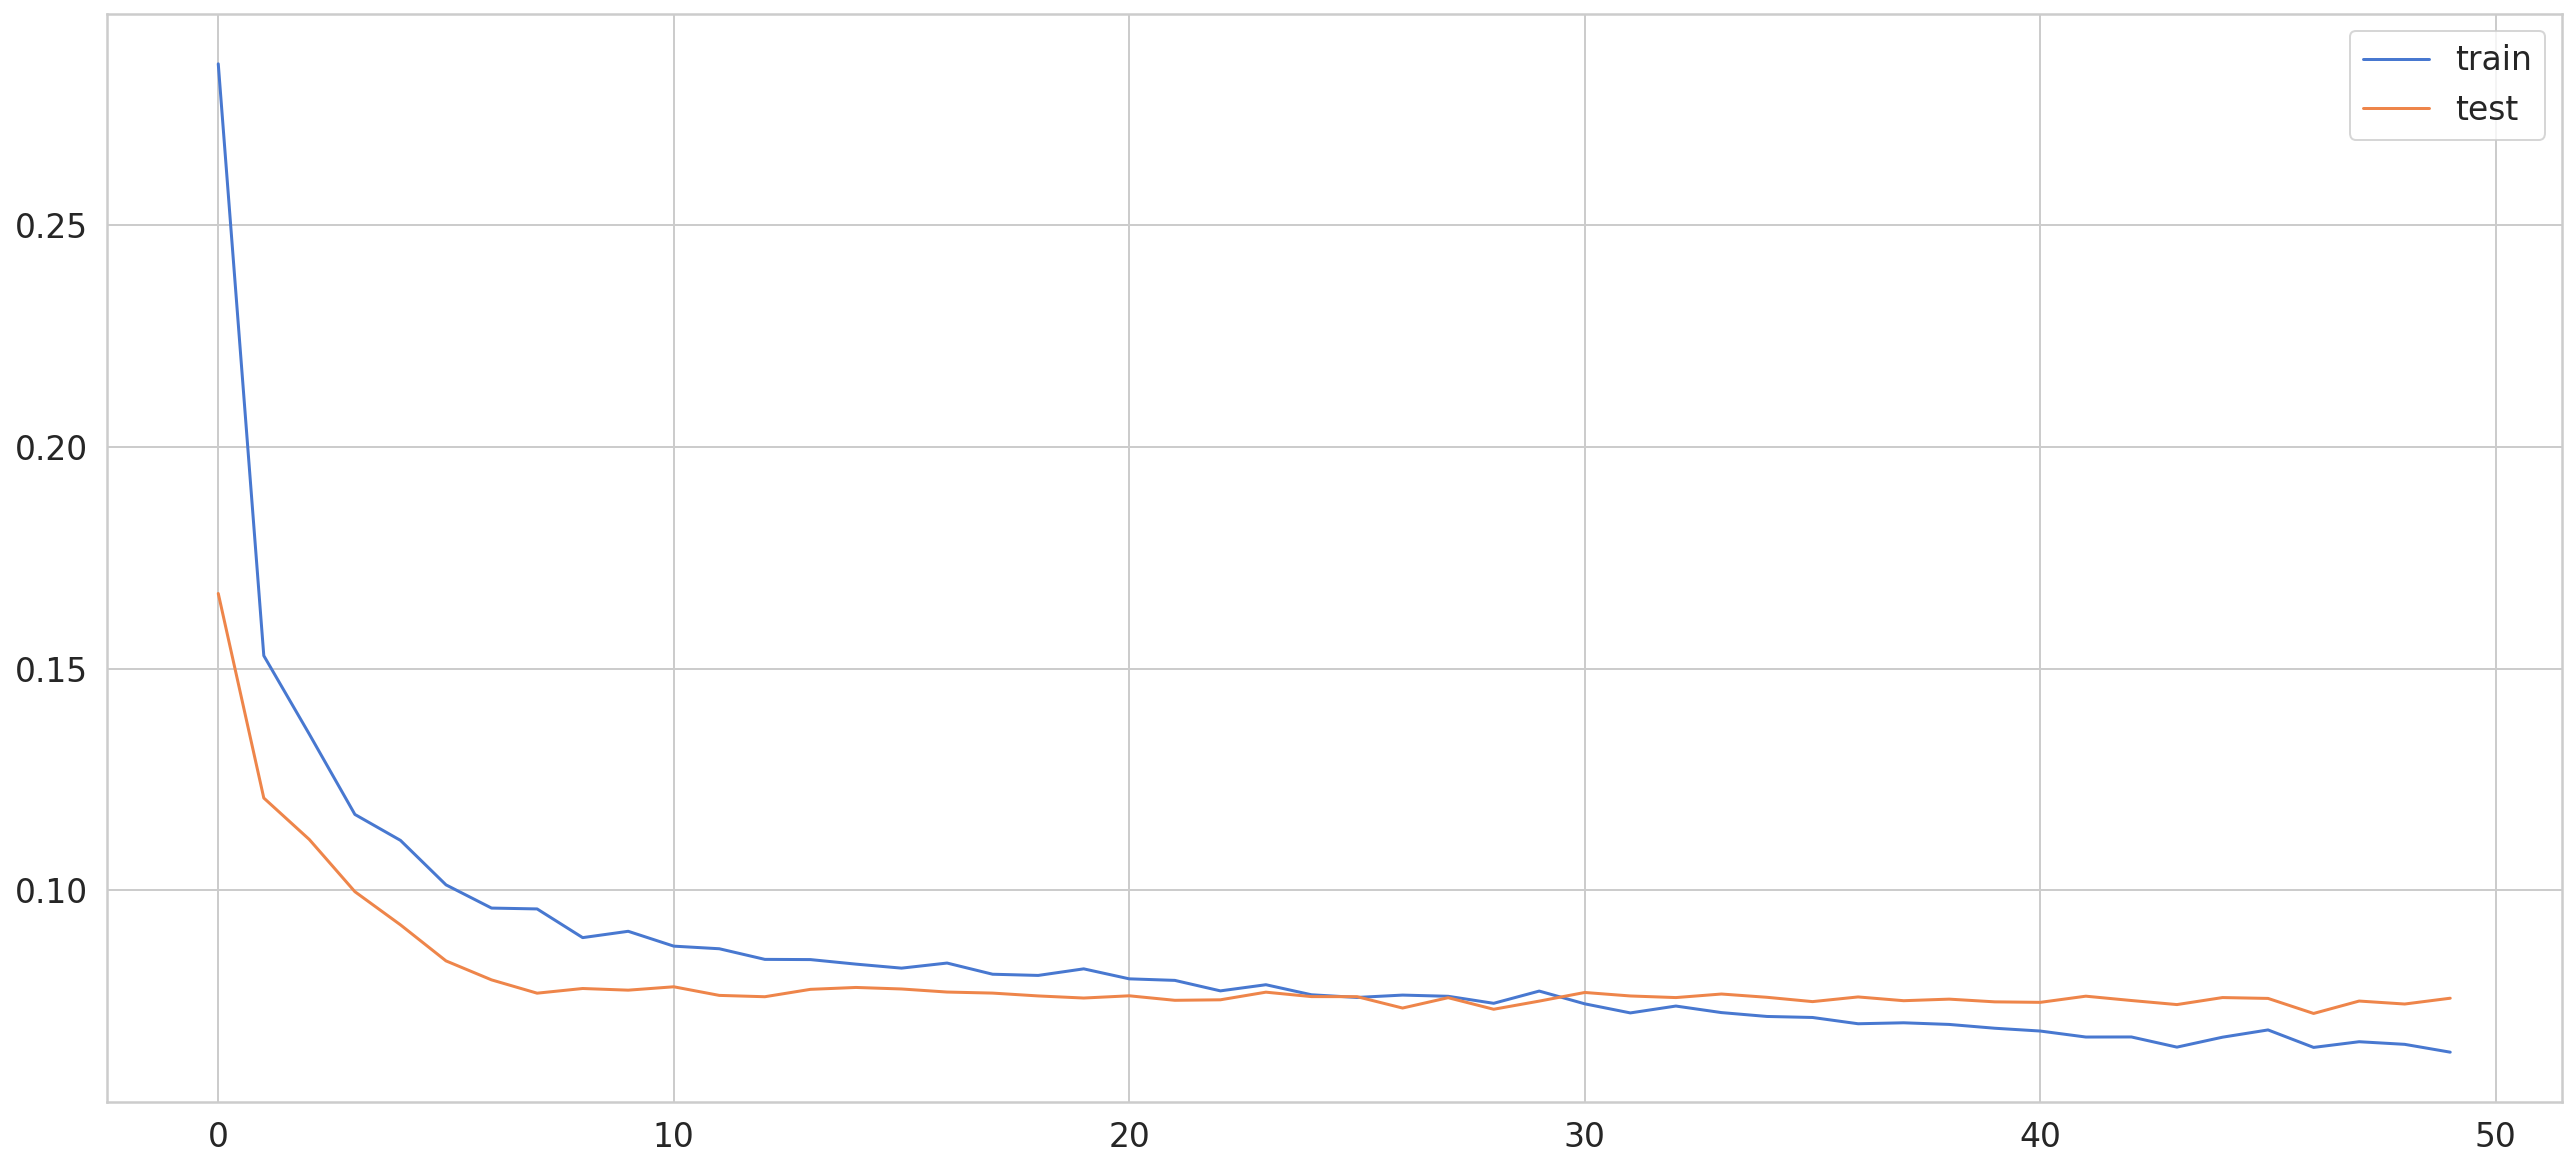

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_train_inv = aqi_transformer.inverse_transform(y_train.reshape(-1,1))
y_test_inv = aqi_transformer.inverse_transform(y_test.reshape(-1,1))
y_pred_inv = aqi_transformer.inverse_transform(y_pred)

In [ ]:
y_test_inv.shape, y_pred_inv.shape

((402, 1), (402, 1))

In [ ]:
df

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,AQI
Date,,,,,,,,,,,,
2015-01-01,0.226154,1.970296,-1.217988,-1.411893,-0.972840,-1.426923,-1.537278,-1.572485,-1.380592,-1.542249,-1.480118,1.165680
2015-01-02,-0.525562,-0.032249,-1.259822,-1.432722,-1.105680,-1.438876,-1.570769,-1.587870,-1.449882,-1.564793,-1.508343,1.059172
2015-01-03,-1.111361,-0.846746,-1.474970,-1.447870,-1.343491,-1.215680,-1.564438,-1.611538,-1.510592,-1.604083,-1.566686,-0.781065
2015-01-04,-0.728757,-0.196213,-1.479231,-1.408817,-1.339527,-0.855858,-1.558935,-1.599822,-1.477160,-1.602012,-1.569763,0.260355
2015-01-05,-0.759763,-0.330592,-1.544320,-1.420592,-1.400888,-0.900118,-1.572781,-1.607515,-1.489941,-1.610651,-1.590473,0.295858
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-27,-1.391716,-0.704497,-1.562840,-1.500237,-1.494260,-1.441243,-1.622071,-1.565799,-1.515503,-1.617219,-1.508935,-0.964497
2020-06-28,-1.275030,0.199112,-1.552249,-1.499408,-1.486036,-1.454024,-1.621657,-1.563905,-1.520414,-1.617101,-1.478521,-0.467456
2020-06-29,-1.361775,-0.537751,-1.565089,-1.499586,-1.497396,-1.461716,-1.622012,-1.558698,-1.469763,-1.614615,-1.486391,-0.248521


In [ ]:
train_data = dataset[:train_size]
valid = dataset[train_size:]
valid['Predictions'] = y_pred_inv

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
valid

,AQI,Predictions
Date,,
2019-05-27,163.0,137.106674
2019-05-28,175.0,177.008057
2019-05-29,191.0,184.917267
2019-05-30,226.0,204.973480
2019-05-31,266.0,266.804016
...,...,...
2020-06-27,112.0,119.672684
2020-06-28,196.0,125.292130
2020-06-29,233.0,242.858704


In [ ]:
rmse=np.sqrt(np.mean(((y_pred_inv - y_test_inv)**2)))
rmse

35.251842069686006

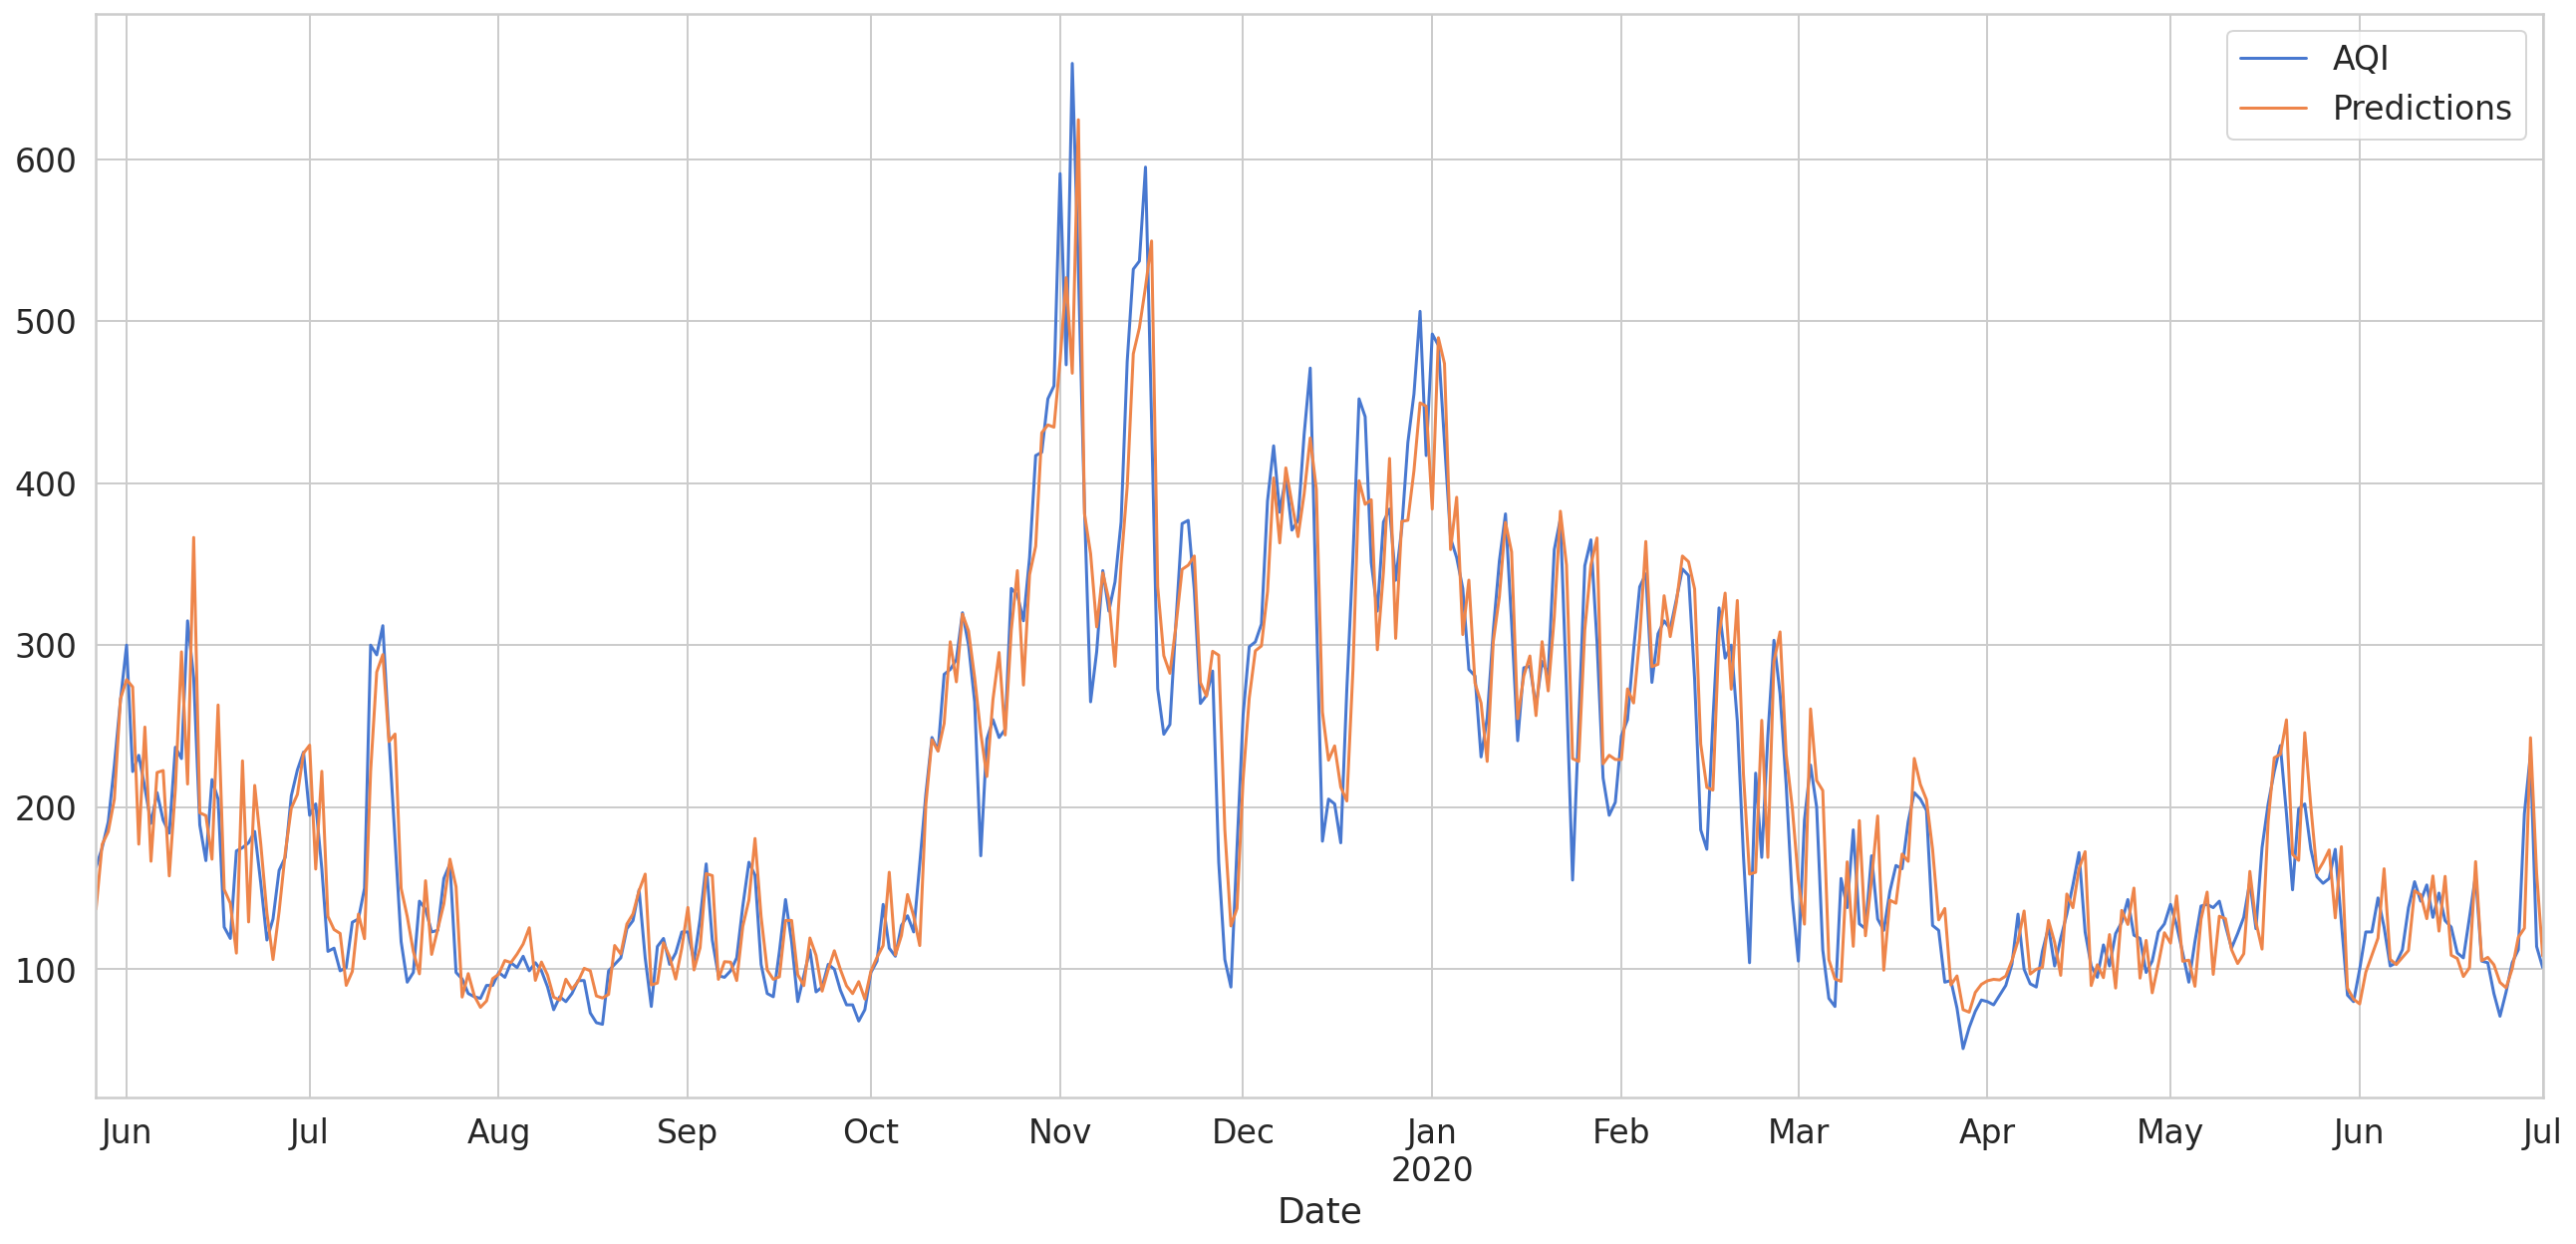

In [ ]:
valid.plot();